# Smartphone and MCU-board data sync
This document provides an example of two independent system time sync:

1. A handheld system with rigidly attached IMU launched by an MCU board.
2. Motion Capture System (mocap) that captures movements of the handheld system by detecting light reflective markers rigidly attached to it.

The task is to find time offset between mocap and imu measurements.

Important clauses:
1. The case of these systems implies __angular velocity extraction from poses given by mocap__. It can be achieved by obtaining finite differences between orientations given by mocap. We do this procedure here.
2. Mocap system may miss poses for some timestamps, this drawback should be considered. The notebook solves this issue.
3. During data recording for this case, mocap system was triggered by MCU GPIO pin, this means there is __no clock drift__ between mocap and IMU data. Thus, only time offset to be estimated here. Clock drift handling to be done in another notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as Rot
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d
import twistnsync as tns

def interp(t_old, f_old, t_new, kind='linear'):
    func = interp1d(t_old, f_old, kind=kind, axis=0, fill_value="extrapolate")
    f_new = func(t_new)
    return f_new

d = np.array([-1.0, 0.0, 1.0])

/tmp/ipykernel_3271847/3628822468.py:6: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


### Mocap data handler class

In [2]:
class MocapData:
    
    def __init__(self, path, fs=None):
        self.df = pd.read_csv(path, compression='zip')
        if fs is not None:
            self.df['timestamps'] = np.arange(self.df['timestamps'].shape[0])/fs
        self.indexes_whole = self.df.index
        self.indexes_notna = self.df[self.df.notna().all(axis=1)].index
    
    def get_data(self, notna_only=True):
        indexes = self.indexes_notna if notna_only else self.indexes_whole
        timestamps = self.df[['timestamps']].to_numpy().squeeze()[indexes]
        quats = self.df[['qx', 'qy', 'qz', 'qw']].to_numpy()[indexes]
        
        return timestamps, quats

### Read IMU timestamps and angular velocities

In [3]:
# imu_data = pd.read_csv('data/imu.zip', compression='zip')
# imu_timestamps = imu_data['t'].to_numpy().squeeze() * 1.0e-9
# imu_ang_vel = imu_data[['ox', 'oy', 'oz']].to_numpy()

# imu_data = pd.read_csv('~/personal/mnt/patata/datasets/mocap_azure_calibration_seqs/s20/02.03.2023/20230302_155329/VID_20230302_155329gyro.csv', 
imu_data = pd.read_csv('~/personal/mnt/patata/datasets/mocap_azure_calibration_seqs/s20/28.02.2023/20200628_072824/VID_20200628_072824gyro.csv',
                    header=None, names = ['ox', 'oy', 'oz', 't'])
imu_timestamps = imu_data['t'].to_numpy().squeeze() * 1.0e-9
imu_ang_vel = imu_data[['ox', 'oy', 'oz']].to_numpy()

In [4]:
imu_timestamps = imu_timestamps - min(imu_timestamps)

In [5]:
max(imu_timestamps) - min(imu_timestamps)

38.72289283387363

In [6]:
imu_data

,ox,oy,oz,t
0,0.005007,0.007206,-0.000630,4148966935834352
1,0.005618,0.007206,-0.001241,4148966941834352
2,0.002563,0.007206,0.001814,4148966943834352
3,0.004396,0.003541,-0.001241,4148966945834352
4,0.005007,0.005985,0.000592,4148966947834602
...,...,...,...,...
19355,-0.040197,0.015758,0.018307,4149005650727054
19356,-0.043252,0.015148,0.020140,4149005652727087
19357,-0.042030,0.020645,0.019529,4149005654727120
19358,-0.045084,0.022478,0.022583,4149005656727153


In [7]:
imu_ang_vel

array([[ 0.00500665,  0.00720638, -0.0006298 ],
       [ 0.00561752,  0.00720638, -0.00124067],
       [ 0.00256319,  0.00720638,  0.00181366],
       ...,
       [-0.04202997,  0.02064541,  0.01952875],
       [-0.0450843 ,  0.02247801,  0.02258308],
       [-0.04569516,  0.02308887,  0.02136135]])

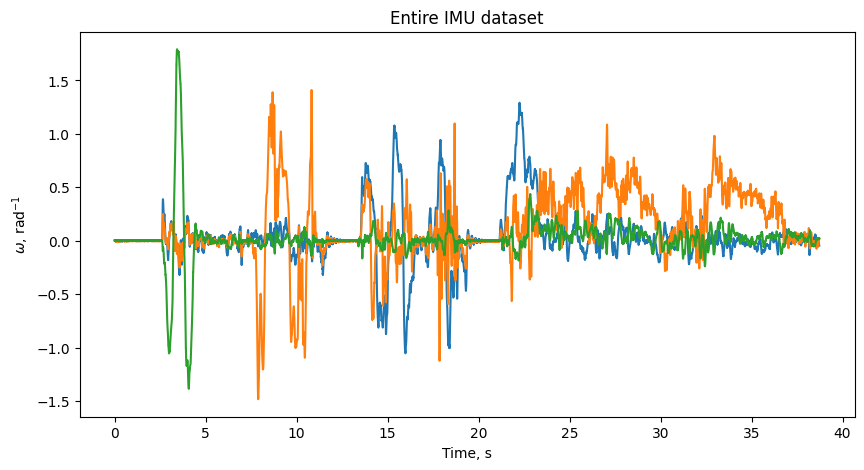

In [8]:
plt.figure(figsize=(10,5))
plt.title('Entire IMU dataset')
plt.xlabel('Time, s')
plt.ylabel(r'$\omega$, rad$^{-1}$')
plt.plot(imu_timestamps, imu_ang_vel);

### Take a look at non-zero IMU bias during motionless state of the platform.
The bias can be already removed if the IMU is calibrated beforehand

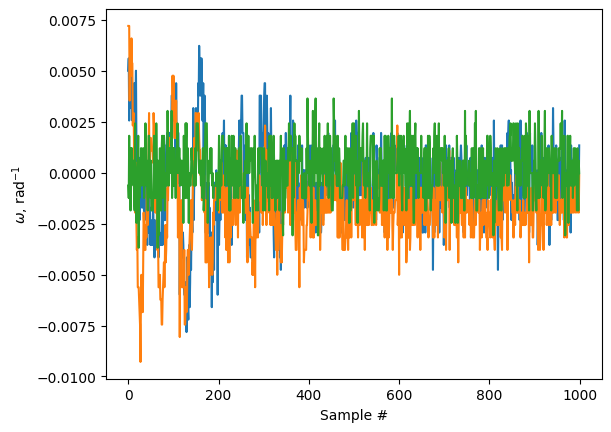

In [9]:
plt.plot(imu_ang_vel[:1000])
plt.xlabel('Sample #')
plt.ylabel(r'$\omega$, rad$^{-1}$');

### Subtracting of the bias from the IMU measurements

In [10]:
imu_ang_vel -= imu_ang_vel[:1000].mean(axis=0)

### Bias is removed:

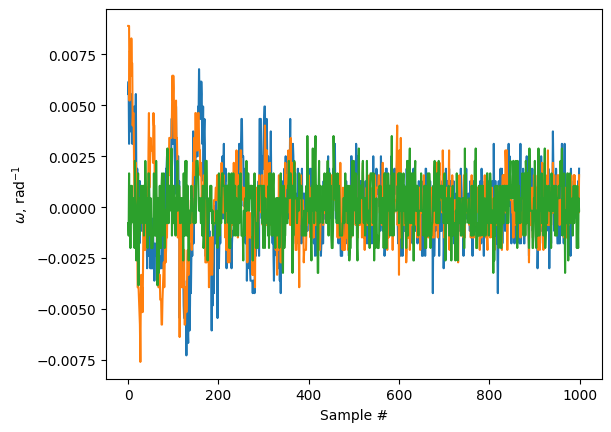

In [11]:
plt.plot(imu_ang_vel[:1000])
plt.xlabel('Sample #')
plt.ylabel(r'$\omega$, rad$^{-1}$');

### Read mocap data including timestamps and orientations

In [12]:
# mocap_data_obj = MocapData('data/mocap.zip', fs=200.)
mocap_data_obj = pd.read_csv('~/personal/mnt/patata/datasets/mocap_azure_calibration_seqs/mocap_files/mocap_s20_2802.csv', 
                    skiprows=6)
mocap_all_timestamps = mocap_data_obj['Time (Seconds)'].to_numpy().squeeze()
mocap_all_quaternions = mocap_data_obj[['X', 'Y', 'Z', 'W']].to_numpy()

indexes_notna = mocap_data_obj[mocap_data_obj.notna().all(axis=1)].index
mocap_notna_timestamps = mocap_all_timestamps[indexes_notna]
mocap_notna_quaternions = mocap_all_quaternions[indexes_notna]
dt = np.diff(mocap_all_timestamps).mean()
print(f'Mocap data sampling period is {dt * 1000.} ms, rate is {1./dt} Hz')

Mocap data sampling period is 5.0 ms, rate is 200.0 Hz


In [13]:
mocap_data_obj

,Frame,Time (Seconds),X,Y,Z,W,X.1,Y.1,Z.1
0,0,0.000,0.584570,0.653068,0.399851,-0.268141,-1.026725,0.413402,1.089476
1,1,0.005,0.584801,0.653876,0.398803,-0.267225,-1.026704,0.413427,1.089507
2,2,0.010,0.584795,0.653673,0.399040,-0.267382,-1.026709,0.413405,1.089508
3,3,0.015,0.584733,0.654247,0.398511,-0.266904,-1.026711,0.413444,1.089528
4,4,0.020,0.584779,0.654175,0.398473,-0.267035,-1.026700,0.413427,1.089507
...,...,...,...,...,...,...,...,...,...
7679,7679,38.395,-0.465848,-0.550495,-0.149294,-0.676500,0.437832,1.300650,-0.834007
7680,7680,38.400,-0.465873,-0.550449,-0.149371,-0.676503,0.437814,1.300663,-0.834016
7681,7681,38.405,-0.465869,-0.550418,-0.149062,-0.676599,0.437806,1.300688,-0.834024
7682,7682,38.410,-0.465951,-0.550516,-0.149472,-0.676373,0.437692,1.300735,-0.834145


In [14]:
len(mocap_all_timestamps), len(mocap_notna_timestamps)

(7684, 7684)

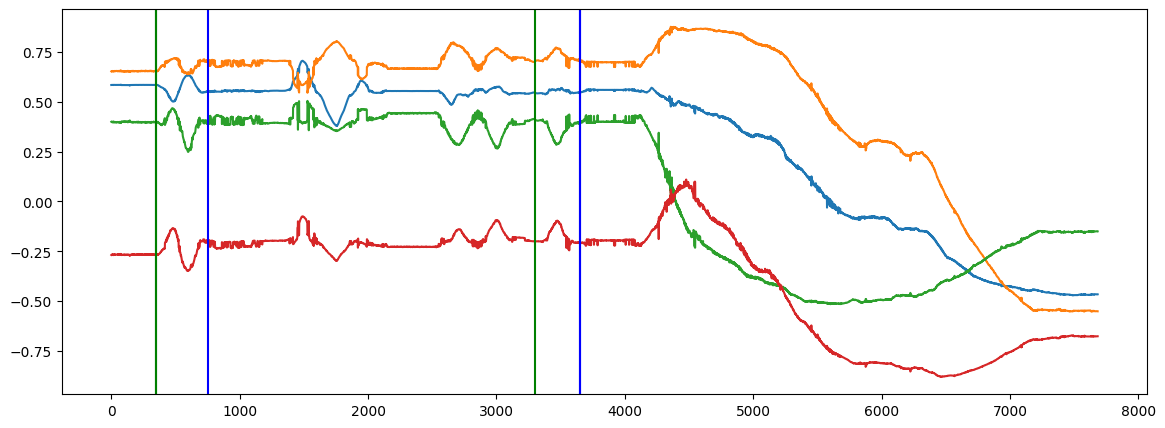

In [15]:
tns_mocap_timestamps = np.array([
    [350, 750], # the _beginning_ and the _end_ of a twistnsync trial (Figure 2.3 
                   # in https://mipt.ru/upload/medialibrary/f8b/dissertatsiya-fayzullin.pdf#figure.caption.16)
    [350, 3650],
    [3300, 3650],
])

plt.figure(figsize=(14,5))
plt.plot(mocap_all_quaternions)

begins = tns_mocap_timestamps[:, 0]
ends = tns_mocap_timestamps[:, 1]

for begin, end in zip(begins, ends):
    plt.axvline(begin, c='g')
    plt.axvline(end, c='b')

In [16]:
def get_mocap_based_angular_velocity(time_notna, quats_notna, time_whole):
    orientation = Rot(quats_notna).as_matrix()
    orientation_interp = interp(time_notna, orientation, time_whole)
    dR = orientation_interp[:-2].transpose(0,2,1) @ orientation_interp[2:]
    dt = (time_whole[2:] - time_whole[:-2]).reshape(-1,1)
    ang_vel = Rot.from_matrix(dR).as_rotvec() / dt
    return ang_vel

mocap_ang_vel = get_mocap_based_angular_velocity(
    mocap_notna_timestamps, mocap_notna_quaternions, mocap_all_timestamps)

In [17]:
imu_ang_vel.min(), imu_ang_vel.max(), imu_ang_vel.mean()

(-1.48039405757676, 1.7914935402123482, 0.06086816120675353)

In [18]:
mocap_ang_vel.min(), mocap_ang_vel.max(), mocap_ang_vel.mean()

(-29.368353293912737, 28.84445192988943, 0.02443371602427472)

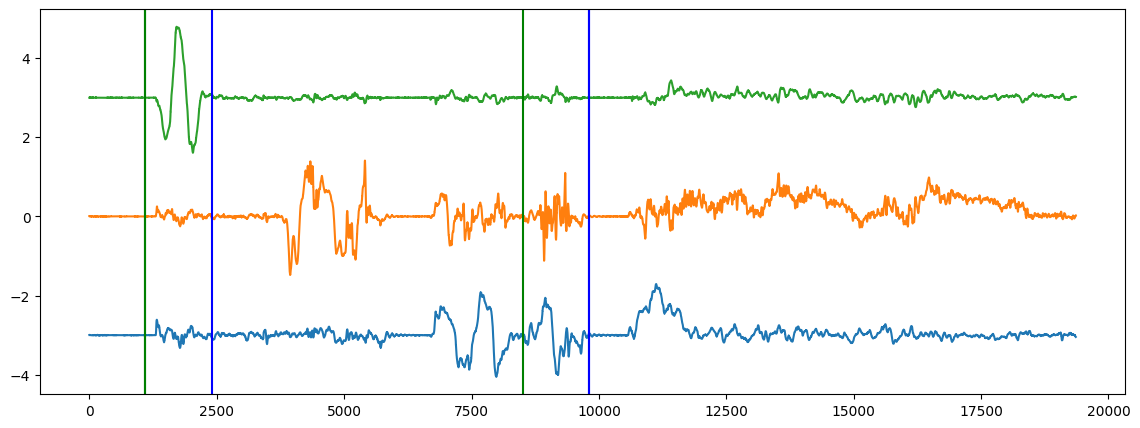

In [19]:
tns_imu_timestamps = np.array([
    [1100, 2400], # the _beginning_ and the _end_ of a twistnsync trial (Figure 2.3 
                   # in https://mipt.ru/upload/medialibrary/f8b/dissertatsiya-fayzullin.pdf#figure.caption.16)
    [1100, 9800],
    [8500, 9800]
])

plt.figure(figsize=(14,5))
plt.plot(imu_ang_vel + d * 3)
for begin, end in zip(tns_imu_timestamps[:, 0], tns_imu_timestamps[:, 1]):
    plt.axvline(begin, c='g')
    plt.axvline(end, c='b')

Estimated offset analyzing Twist-n-sync trial 0 is -0.8146819269821755 seconds.
Estimated offset analyzing Twist-n-sync trial 1 is -0.8542876245746898 seconds.
Estimated offset analyzing Twist-n-sync trial 2 is -0.5969122844930871 seconds.


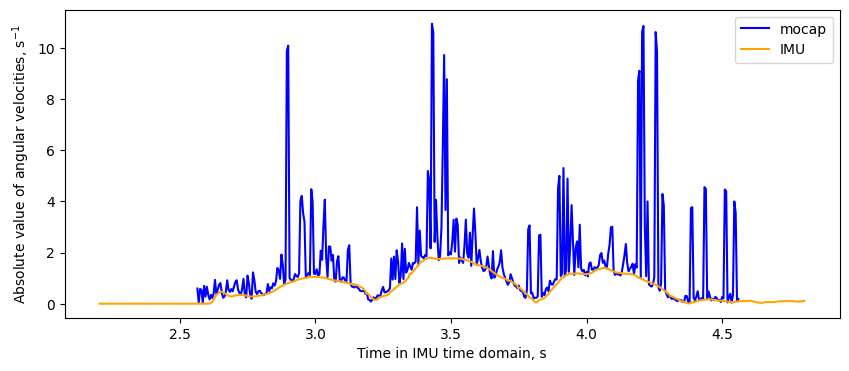

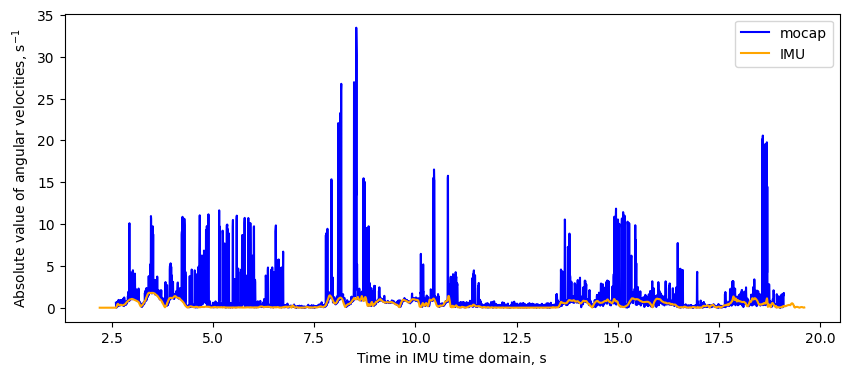

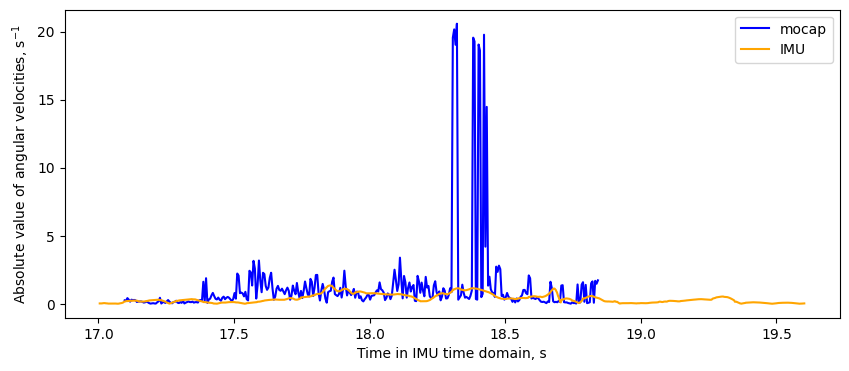

In [20]:
offsets = []
for i in range(tns_mocap_timestamps.shape[0]):    
    mocap_t = mocap_all_timestamps[tns_mocap_timestamps[i, 0]:tns_mocap_timestamps[i, 1]]
    mocap_av = mocap_ang_vel[tns_mocap_timestamps[i, 0]:tns_mocap_timestamps[i, 1]]
    imu_t = imu_timestamps[tns_imu_timestamps[i, 0]:tns_imu_timestamps[i, 1]]
    imu_av = imu_ang_vel[tns_imu_timestamps[i, 0]:tns_imu_timestamps[i, 1]]
    
    time_sync = tns.TimeSync(
        imu_av, mocap_av, imu_t, mocap_t, do_resample = True
    )
    time_sync.resample()
    time_sync.obtain_delay()
    # Check if IMU calibration and consequently TimeSync has succeeded
    if time_sync.calibration_is_succeeded == False or time_sync.calibration_is_succeeded is None:
        print('Warning! IMU data calibration failed. May affect sync result.')

    comp_delay = time_sync.time_delay
    M = time_sync.M
    # Compute resulting offset
    mocap_imu_clock_offset = (mocap_t[0] - imu_t[0] + comp_delay)
    offsets.append(mocap_imu_clock_offset)
    print(f'Estimated offset analyzing Twist-n-sync trial {i} is {mocap_imu_clock_offset} seconds.')
    plt.figure(figsize=(10,4))
    plt.plot(mocap_t - mocap_imu_clock_offset, np.linalg.norm(mocap_av, ord=2, axis=1), 'b', label='mocap')
    plt.plot(imu_t, np.linalg.norm(imu_av, ord=2, axis=1), 'orange', label='IMU')
    plt.xlabel('Time in IMU time domain, s')
    plt.ylabel(r'Absolute value of angular velocities, s$^{-1}$')
    plt.legend()


In [21]:
deviation = np.array(offsets).std().round(8) * 1.e6
print(f'Precision of estimates is {deviation} microseconds of standard deviation.')

Precision of estimates is 113153.92 microseconds of standard deviation.


# This is the final result, mocap timestamps in the IMU data time domain
based on the last Twist-n-sync trial

In [22]:
mocap_all_timestamps_aligned = mocap_all_timestamps - mocap_imu_clock_offset
mocap_notna_timestamps_aligned = mocap_notna_timestamps - mocap_imu_clock_offset

In [23]:
mocap_all_timestamps_aligned

array([ 0.59691228,  0.60191228,  0.60691228, ..., 39.00191228,
       39.00691228, 39.01191228])

In [24]:
mocap_all_timestamps_aligned[1:] - mocap_all_timestamps_aligned[:-1]

array([0.005, 0.005, 0.005, ..., 0.005, 0.005, 0.005])

In [56]:
import cv2

vidcap = cv2.VideoCapture('../mnt/patata/datasets/mocap_azure_calibration_seqs/s20/28.02.2023/VID_20200628_072824.mp4')
fps = vidcap.get(cv2.CAP_PROP_FPS)
success,image = vidcap.read()
count = 0
success = True

all_timestamps = []

while success:
    success,frame = vidcap.read()
    count+=1
    all_timestamps.append(int(round(count/fps, 3) * 1000))
    print("time stamp current frame:", all_timestamps[-1])
    cv2.imwrite('frames_from_2802_video/{:03d}.png'.format(all_timestamps[-1]), frame)
    # break

time stamp current frame: 33
time stamp current frame: 67
time stamp current frame: 100
time stamp current frame: 133
time stamp current frame: 167
time stamp current frame: 200
time stamp current frame: 233
time stamp current frame: 267
time stamp current frame: 300
time stamp current frame: 333
time stamp current frame: 367
time stamp current frame: 400
time stamp current frame: 433
time stamp current frame: 467
time stamp current frame: 500
time stamp current frame: 533
time stamp current frame: 567
time stamp current frame: 600
time stamp current frame: 633
time stamp current frame: 667
time stamp current frame: 700
time stamp current frame: 733
time stamp current frame: 767
time stamp current frame: 800
time stamp current frame: 833
time stamp current frame: 867
time stamp current frame: 900
time stamp current frame: 933
time stamp current frame: 967
time stamp current frame: 1000
time stamp current frame: 1033
time stamp current frame: 1066
time stamp current frame: 1100
time sta

error: OpenCV(4.7.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:783: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [54]:
help(vidcap.read)

Help on built-in function read:

read(...) method of cv2.VideoCapture instance
    read([, image]) -> retval, image
    .   @brief Grabs, decodes and returns the next video frame.
    .   
    .       @param [out] image the video frame is returned here. If no frames has been grabbed the image will be empty.
    .       @return `false` if no frames has been grabbed
    .   
    .       The method/function combines VideoCapture::grab() and VideoCapture::retrieve() in one call. This is the
    .       most convenient method for reading video files or capturing data from decode and returns the just
    .       grabbed frame. If no frames has been grabbed (camera has been disconnected, or there are no more
    .       frames in video file), the method returns false and the function returns empty image (with %cv::Mat, test it with Mat::empty()).
    .   
    .       @note In @ref videoio_c "C API", functions cvRetrieveFrame() and cv.RetrieveFrame() return image stored inside the video
    . 

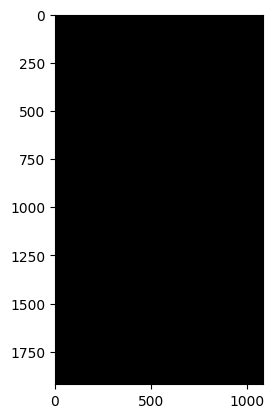

In [50]:
plt.imshow(frame)

In [47]:
vidcap.open('../personal/mnt/patata/datasets/mocap_azure_calibration_seqs/s20/28.02.2023/VID_20200628_072824.mp4')

False

In [60]:
import os
os.listdir('../mnt')

['patata']

## Visualization

### No sync

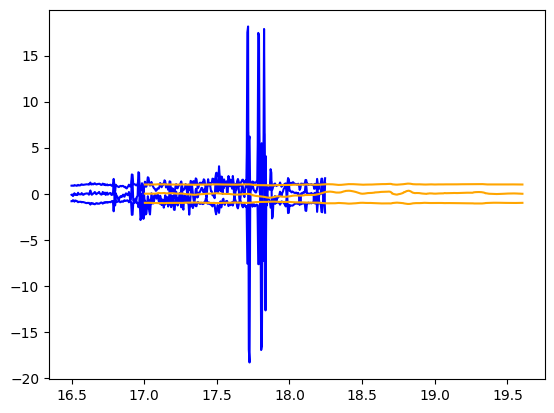

In [29]:
plt.plot(mocap_t, mocap_av + d, 'b')
plt.plot(imu_t, (time_sync.M @ imu_av.T).T + d, 'orange')

## Sunchronized but not aligned angular velocities

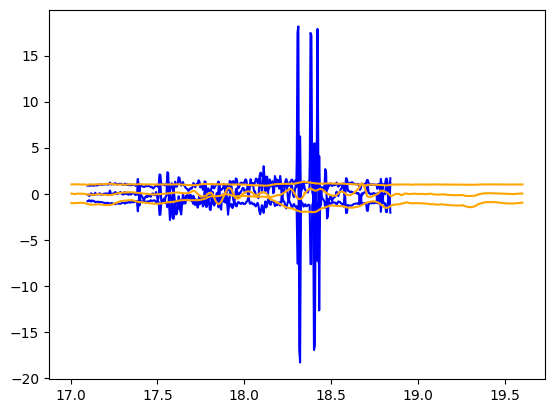

In [30]:
plt.plot(mocap_t - mocap_imu_clock_offset, mocap_av + d, 'b')
plt.plot(imu_t, imu_av + d, 'orange')


## Sunchronized and aligned angular velocities

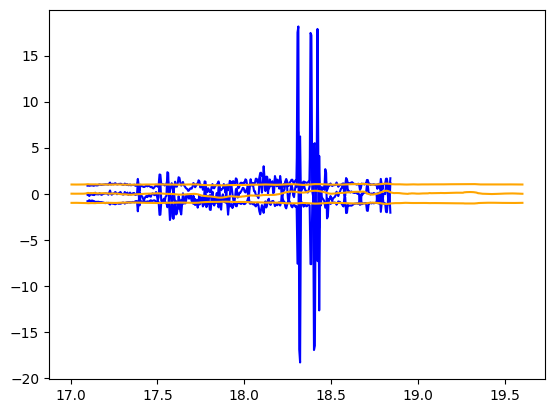

In [31]:
plt.plot(mocap_t - mocap_imu_clock_offset, mocap_av + d, 'b')
plt.plot(imu_t, (time_sync.M @ imu_av.T).T + d, 'orange')


### Read poses and clean them

In [2]:
new_poses = pd.read_csv('mocap_poses_with_aligned_timestamps.csv')

In [11]:
new_poses.columns

Index(['X', 'Y', 'Z', 'W', 'X.1', 'Y.1', 'Z.1', 'IMU_Timestamp'], dtype='object')

In [10]:
new_poses = new_poses.drop('Unnamed: 0', axis=1)

In [12]:
new_poses

,X,Y,Z,W,X.1,Y.1,Z.1,IMU_Timestamp
0,0.584570,0.653068,0.399851,-0.268141,-1.026725,0.413402,1.089476,600.0
1,0.584801,0.653876,0.398803,-0.267225,-1.026704,0.413427,1.089507,600.0
2,0.584795,0.653673,0.399040,-0.267382,-1.026709,0.413405,1.089508,600.0
3,0.584733,0.654247,0.398511,-0.266904,-1.026711,0.413444,1.089528,600.0
4,0.584779,0.654175,0.398473,-0.267035,-1.026700,0.413427,1.089507,633.0
...,...,...,...,...,...,...,...,...
7679,-0.465848,-0.550495,-0.149294,-0.676500,0.437832,1.300650,-0.834007,NaN
7680,-0.465873,-0.550449,-0.149371,-0.676503,0.437814,1.300663,-0.834016,NaN
7681,-0.465869,-0.550418,-0.149062,-0.676599,0.437806,1.300688,-0.834024,NaN
7682,-0.465951,-0.550516,-0.149472,-0.676373,0.437692,1.300735,-0.834145,NaN


In [40]:
cleaned_poses = new_poses[new_poses['IMU_Timestamp'] == 600.0].drop([0,1,2,3])
cleaned_poses

,X,Y,Z,W,X.1,Y.1,Z.1,IMU_Timestamp


In [41]:
imu_timestamps = np.array(new_poses['IMU_Timestamp'])

In [42]:
for timestamp in np.unique(imu_timestamps):
    quant = new_poses[new_poses['IMU_Timestamp'] == timestamp]
    # print(quant)
    # print(np.mean(quant, axis=0))
    cleaned_poses.loc[len(cleaned_poses)] = np.mean(quant, axis=0)
    # break

In [45]:
cleaned_poses = cleaned_poses.drop([1121])
cleaned_poses

,X,Y,Z,W,X.1,Y.1,Z.1,IMU_Timestamp
0,0.584725,0.653716,0.399051,-0.267413,-1.026712,0.413419,1.089505,600.0
1,0.584788,0.654034,0.398662,-0.267076,-1.026708,0.413428,1.089501,633.0
2,0.584776,0.654288,0.398387,-0.266886,-1.026702,0.413439,1.089507,667.0
3,0.584785,0.654104,0.398591,-0.267018,-1.026703,0.413428,1.089501,700.0
4,0.584851,0.654483,0.398098,-0.266683,-1.026698,0.413449,1.089512,733.0
...,...,...,...,...,...,...,...,...
1116,-0.466771,-0.547856,-0.152746,-0.677235,0.445169,1.300189,-0.831378,37794.0
1117,-0.466534,-0.548770,-0.152685,-0.676672,0.445438,1.300239,-0.831112,37827.0
1118,-0.466709,-0.549315,-0.152152,-0.676228,0.445753,1.300453,-0.830898,37861.0
1119,-0.467437,-0.549941,-0.153250,-0.674968,0.446105,1.300841,-0.830722,37894.0


In [49]:
cleaned_poses['IMU_Timestamp'] = [int(x) for x in list(cleaned_poses['IMU_Timestamp'])]

In [50]:
cleaned_poses

,X,Y,Z,W,X.1,Y.1,Z.1,IMU_Timestamp
0,0.584725,0.653716,0.399051,-0.267413,-1.026712,0.413419,1.089505,600
1,0.584788,0.654034,0.398662,-0.267076,-1.026708,0.413428,1.089501,633
2,0.584776,0.654288,0.398387,-0.266886,-1.026702,0.413439,1.089507,667
3,0.584785,0.654104,0.398591,-0.267018,-1.026703,0.413428,1.089501,700
4,0.584851,0.654483,0.398098,-0.266683,-1.026698,0.413449,1.089512,733
...,...,...,...,...,...,...,...,...
1116,-0.466771,-0.547856,-0.152746,-0.677235,0.445169,1.300189,-0.831378,37794
1117,-0.466534,-0.548770,-0.152685,-0.676672,0.445438,1.300239,-0.831112,37827
1118,-0.466709,-0.549315,-0.152152,-0.676228,0.445753,1.300453,-0.830898,37861
1119,-0.467437,-0.549941,-0.153250,-0.674968,0.446105,1.300841,-0.830722,37894


In [53]:
cleaned_poses_without_timestamps = cleaned_poses.drop('IMU_Timestamp', axis=1)
cleaned_poses_without_timestamps

,X,Y,Z,W,X.1,Y.1,Z.1
0,0.584725,0.653716,0.399051,-0.267413,-1.026712,0.413419,1.089505
1,0.584788,0.654034,0.398662,-0.267076,-1.026708,0.413428,1.089501
2,0.584776,0.654288,0.398387,-0.266886,-1.026702,0.413439,1.089507
3,0.584785,0.654104,0.398591,-0.267018,-1.026703,0.413428,1.089501
4,0.584851,0.654483,0.398098,-0.266683,-1.026698,0.413449,1.089512
...,...,...,...,...,...,...,...
1116,-0.466771,-0.547856,-0.152746,-0.677235,0.445169,1.300189,-0.831378
1117,-0.466534,-0.548770,-0.152685,-0.676672,0.445438,1.300239,-0.831112
1118,-0.466709,-0.549315,-0.152152,-0.676228,0.445753,1.300453,-0.830898
1119,-0.467437,-0.549941,-0.153250,-0.674968,0.446105,1.300841,-0.830722


In [67]:
timestamp_to_pose = {}
for i in range(len(cleaned_poses)):
    timestamp_to_pose[int(cleaned_poses.iloc[i]['IMU_Timestamp'])] = tuple(cleaned_poses_without_timestamps.iloc[i])

In [57]:
import json

In [68]:
with open('mocap_poses_with_aligned_timestamps_filtered.json', 'w') as f:
    json.dump(timestamp_to_pose, f)